<a href="https://colab.research.google.com/github/ad-astra-per-ardua/DataAnalysis/blob/main/LTSM_Model_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from statsmodels.tsa.filters.hp_filter import hpfilter


loss_function = Huber(delta=1.0)


In [9]:
log_dir = "./logs"
stock_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
closing_prices = stock_data['Close'].values

closing_prices = pd.Series(closing_prices.flatten()).interpolate().values

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [10]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(closing_prices_scaled, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (556, 60, 1), y_train shape: (556, 1)


In [11]:
model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('enhanced_lstm_model.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir="./logs"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 512)             │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 256)             │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,045,569 (7.80 MB)

 Trainable params: 2,045,569 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.1003 - mae: 0.3826 - val_loss: 0.0282 - val_mae: 0.2270 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0123 - mae: 0.1302 - val_loss: 0.0060 - val_mae: 0.0940 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0046 - mae: 0.0797 - val_loss: 0.0020 - val_mae: 0.0527 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0024 - mae: 0.0574 - val_loss: 0.0020 - val_mae: 0.0513 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0016 - mae: 0.0443 - val_loss: 0.0020 - val_mae: 0.0524 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0016 - mae: 0.0428 - val_loss: 0.0018 - val_mae: 0.0517 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0014 - mae: 0.0418 - val_loss: 0.0020 - val_mae: 0.0536 - learning_rate: 0.0010
Epoch 8/100
9/9 ━━━

In [12]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step


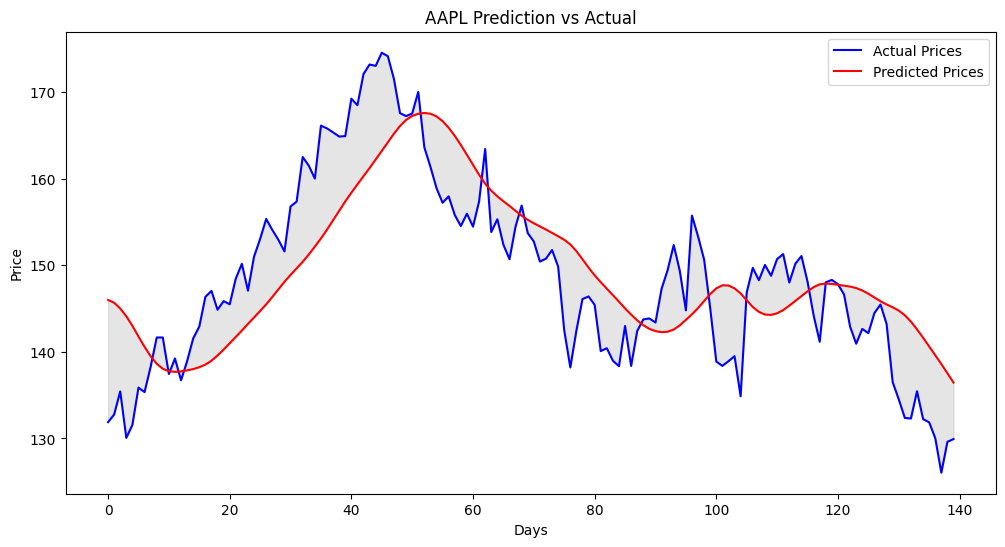

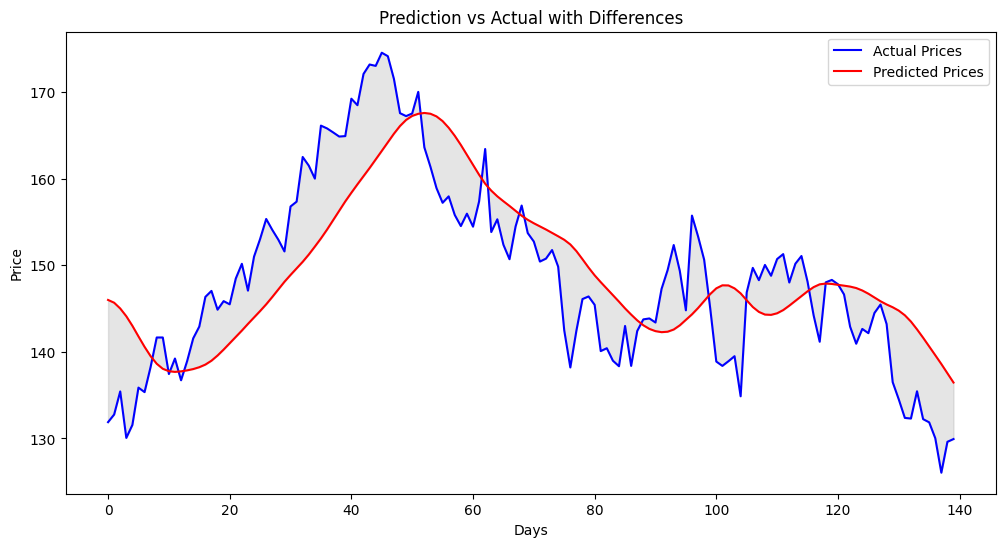

In [ ]:
# Declare visualizing plots

def plot_predictions(actual, predicted, title="Price Prediction"):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices', color='blue')
    plt.plot(predicted, label='Predicted Prices', color='red')
    plt.fill_between(range(len(actual)), actual.flatten(), predicted.flatten(), color="gray", alpha=0.2)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def compare_predictions(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.fill_between(range(len(actual)), actual.flatten(), predicted.flatten(), color="gray", alpha=0.2)
    plt.title("Prediction vs Actual with Differences")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

plot_predictions(actual_prices, predicted_prices, title="AAPL Prediction vs Actual")
compare_predictions(actual_prices, predicted_prices)

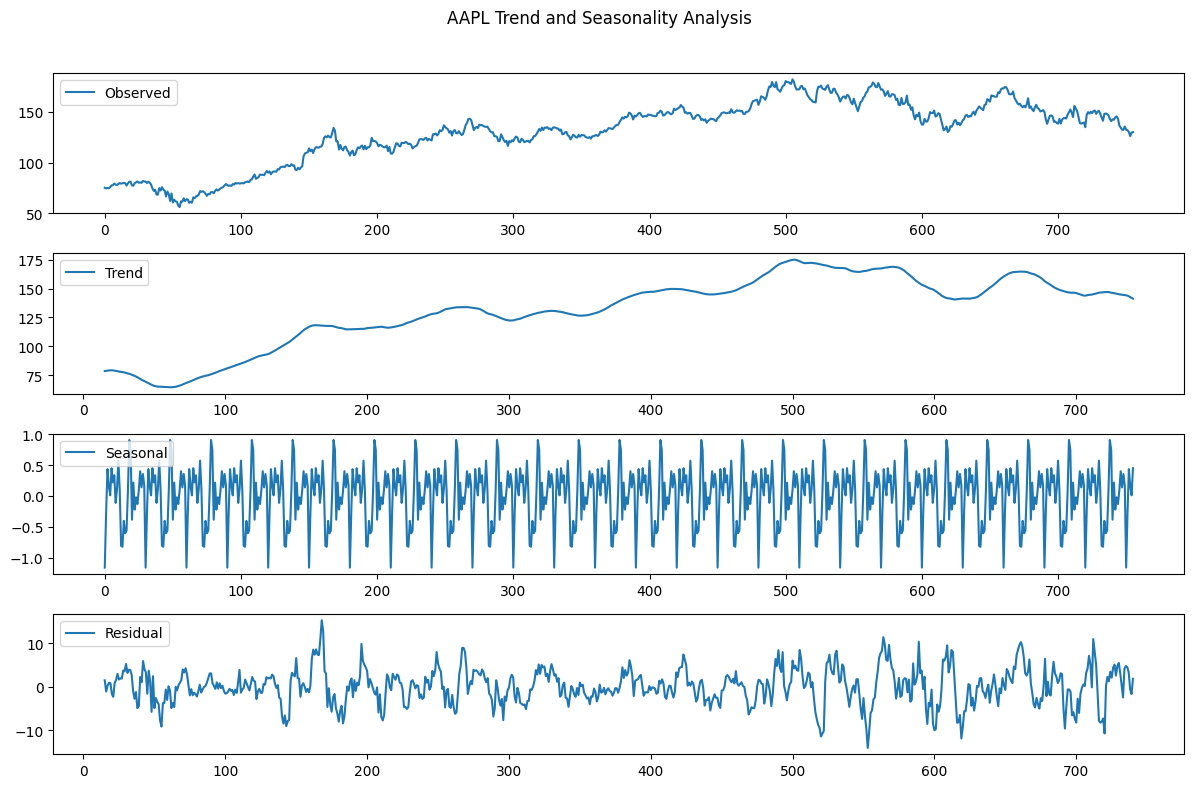

In [13]:
# Seasonality and trend

def plot_trend_and_seasonality(data, title="Trend and Seasonality Analysis"):
    result = seasonal_decompose(data, model='additive', period=30)
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(result.observed, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(result.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

def detrend_data(data):
    result = seasonal_decompose(data, model='additive', period=30)
    detrended = data - result.trend
    detrended = pd.Series(detrended).fillna(0).values
    return detrended

plot_trend_and_seasonality(closing_prices, title="AAPL Trend and Seasonality Analysis")
closing_prices_detrended = detrend_data(closing_prices)
closing_prices_detrended_scaled = scaler.fit_transform(closing_prices_detrended.reshape(-1, 1))

In [14]:
closing_prices_detrended = detrend_data(closing_prices)
closing_prices_detrended_scaled = scaler.fit_transform(closing_prices_detrended.reshape(-1, 1))
X_detrended, y_detrended = create_sequences(closing_prices_detrended, sequence_length)
X_train_detrended = X_train_detrended.reshape(X_train_detrended.shape[0], X_train_detrended.shape[1], 1)
X_test_detrended = X_test_detrended.reshape(X_test_detrended.shape[0], X_test_detrended.shape[1], 1)
if len(y_train_detrended.shape) == 1:
    y_train_detrended = y_train_detrended.reshape(-1, 1)
if len(y_test_detrended.shape) == 1:
    y_test_detrended = y_test_detrended.reshape(-1, 1)


NameError: name 'X_train_detrended' is not defined

In [ ]:
history_detrended = model.fit(
    X_train_detrended, y_train_detrended,
    validation_data=(X_test_detrended, y_test_detrended),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.5880 - mae: 3.0604 - val_loss: 3.0068 - val_mae: 3.4645 - learning_rate: 7.8125e-06
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.6284 - mae: 3.0958 - val_loss: 2.9804 - val_mae: 3.4381 - learning_rate: 7.8125e-06
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.4998 - mae: 2.9644 - val_loss: 2.9599 - val_mae: 3.4171 - learning_rate: 7.8125e-06
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.3991 - mae: 2.8521 - val_loss: 2.9417 - val_mae: 3.3970 - learning_rate: 7.8125e-06
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.5041 - mae: 2.9617 - val_loss: 2.9237 - val_mae: 3.3780 - learning_rate: 7.8125e-06
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.5742 - mae: 3.0333 - val_loss: 2.9095 - val_mae: 3.3632 - learning_rate: 7.8125e-06
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.3992 - mae: 2.8573 - val_loss: 2.8969 - val_mae: 3.3507 - learning_rate: 7.8

In [ ]:
# Prediction after Detrend

history_detrended = model.fit(
    X_train_detrended, y_train_detrended,
    validation_data=(X_test_detrended, y_test_detrended),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 2.5299 - mae: 2.9987 - val_loss: 2.9906 - val_mae: 3.4470 - learning_rate: 7.8125e-06
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.6546 - mae: 3.1209 - val_loss: 2.9723 - val_mae: 3.4283 - learning_rate: 7.8125e-06
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.3402 - mae: 2.8003 - val_loss: 2.9569 - val_mae: 3.4111 - learning_rate: 7.8125e-06
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.5461 - mae: 3.0036 - val_loss: 2.9434 - val_mae: 3.3965 - learning_rate: 7.8125e-06
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.6496 - mae: 3.1146 - val_loss: 2.9298 - val_mae: 3.3824 - learning_rate: 7.8125e-06
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.4181 - mae: 2.8752 - val_loss: 2.9176 - val_mae: 3.3697 - learning_rate: 7.8125e-06
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.4585 - mae: 2.9169 - val_loss: 2.9068 - val_mae: 3.3589 - learning_rate: 7.8

In [ ]:
aapl_trend, aapl_detrended = hpfilter(closing_prices, lamb=1600)

# 잔차 데이터 정규화
scaler_detrended = MinMaxScaler(feature_range=(0, 1))
aapl_detrended_scaled = scaler_detrended.fit_transform(aapl_detrended.reshape(-1, 1))

# 추세 데이터 정규화 (필요 시)
scaler_trend = MinMaxScaler(feature_range=(0, 1))
aapl_trend_scaled = scaler_trend.fit_transform(aapl_trend.reshape(-1, 1))

# 잔차 데이터로 시퀀스 생성
X_train_detrended, y_train_detrended = create_sequences(aapl_detrended_scaled[:train_size], sequence_length)
X_test_detrended, y_test_detrended = create_sequences(aapl_detrended_scaled[train_size:], sequence_length)

# LSTM 모델 학습 (잔차 데이터)
history_detrended = model.fit(
    X_train_detrended, y_train_detrended,
    validation_data=(X_test_detrended, y_test_detrended),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

# 잔차 예측
predicted_prices_detrended = model.predict(X_test_detrended)

# 추세 복원
start_idx = train_size + sequence_length
end_idx = start_idx + len(predicted_prices_detrended)

# 슬라이싱 범위 초과 방지
if end_idx > len(aapl_trend):
    end_idx = len(aapl_trend)

# 추세 데이터와 잔차 결합
trend_component = aapl_trend[start_idx:end_idx].reshape(-1, 1)
predicted_prices_restored = scaler_detrended.inverse_transform(predicted_prices_detrended) + trend_component

# 실제 값 복원
actual_prices_restored = closing_prices[train_size + sequence_length:train_size + sequence_length + len(predicted_prices_restored)].reshape(-1, 1)

# 길이 맞추기
min_len = min(len(actual_prices_restored), len(predicted_prices_restored))
actual_prices_restored = actual_prices_restored[:min_len]
predicted_prices_restored = predicted_prices_restored[:min_len]

# 시각화
plot_predictions(actual_prices_restored, predicted_prices_restored, title="AAPL Prediction with HP Filter Restoration")
compare_predictions(actual_prices_restored, predicted_prices_restored)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0790 - mae: 0.3157 - val_loss: 0.0177 - val_mae: 0.1779 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0080 - mae: 0.1067 - val_loss: 0.0031 - val_mae: 0.0697 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0033 - mae: 0.0695 - val_loss: 0.0017 - val_mae: 0.0440 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0020 - mae: 0.0505 - val_loss: 0.0029 - val_mae: 0.0605 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0016 - mae: 0.0443 - val_loss: 0.0024 - val_mae: 0.0534 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0018 - mae: 0.0483 - val_loss: 0.0015 - val_mae: 0.0422 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 9.5557e-04 - mae: 0.0359 - val_loss: 0.0011 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 8/100
8/8 ━━━━━━━

In [ ]:
# Start of BTC Part
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01')
btc_closing_prices = btc_data['Close'].values
btc_closing_prices = pd.Series(btc_closing_prices.flatten()).interpolate().values

btc_scaler = MinMaxScaler(feature_range=(0, 1))
btc_closing_prices_scaled = btc_scaler.fit_transform(btc_closing_prices.reshape(-1, 1))

X_btc, y_btc = create_sequences(btc_closing_prices_scaled, sequence_length)
train_size_btc = int(len(X_btc) * 0.8)
X_train_btc, X_test_btc = X_btc[:train_size_btc], X_btc[train_size_btc:]
y_train_btc, y_test_btc = y_btc[:train_size_btc], y_btc[train_size_btc:]


[*********************100%***********************]  1 of 1 completed


In [ ]:
btc_model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

btc_model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['mae'])

btc_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('enhanced_lstm_model.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir="./logs"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
btc_history = btc_model.fit(
    X_train_btc, y_train_btc,
    validation_data=(X_test_btc, y_test_btc),
    epochs=100,
    batch_size=64,
    callbacks=btc_callbacks
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0580 - mae: 0.2540 - val_loss: 3.5760e-04 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0077 - mae: 0.0940 - val_loss: 5.4223e-04 - val_mae: 0.0214 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0025 - mae: 0.0500 - val_loss: 0.0014 - val_mae: 0.0406 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0019 - mae: 0.0435 - val_loss: 0.0019 - val_mae: 0.0530 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0018 - mae: 0.0437 - val_loss: 8.6556e-04 - val_mae: 0.0295 - learning_rate: 5.0000e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0017 - mae: 0.0408 - val_loss: 7.8874e-04 - val_mae: 0.0275 - learning_rate: 5.0000e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0015 - mae: 0.0391 - val_loss: 5.9938e-04 - val_mae: 0.0226 - 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


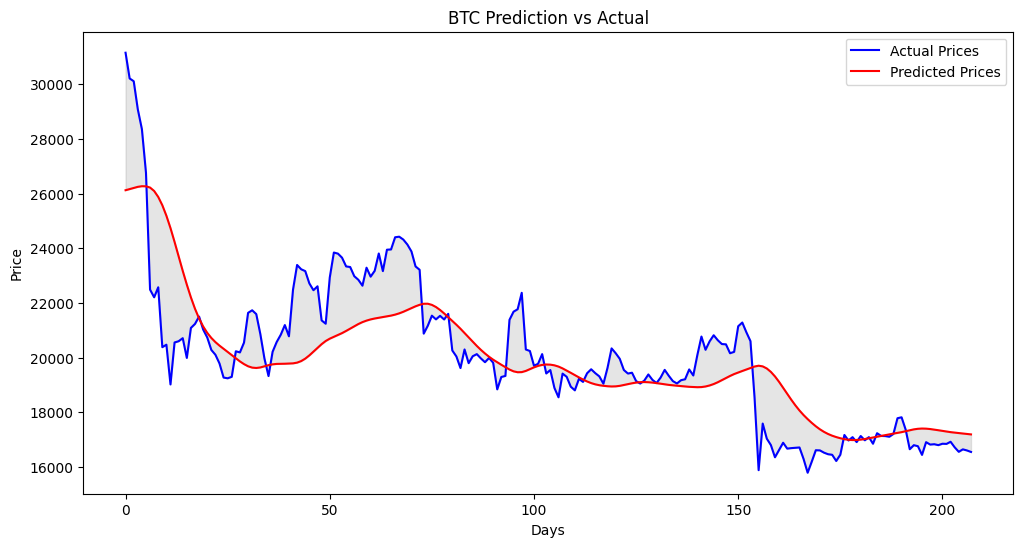

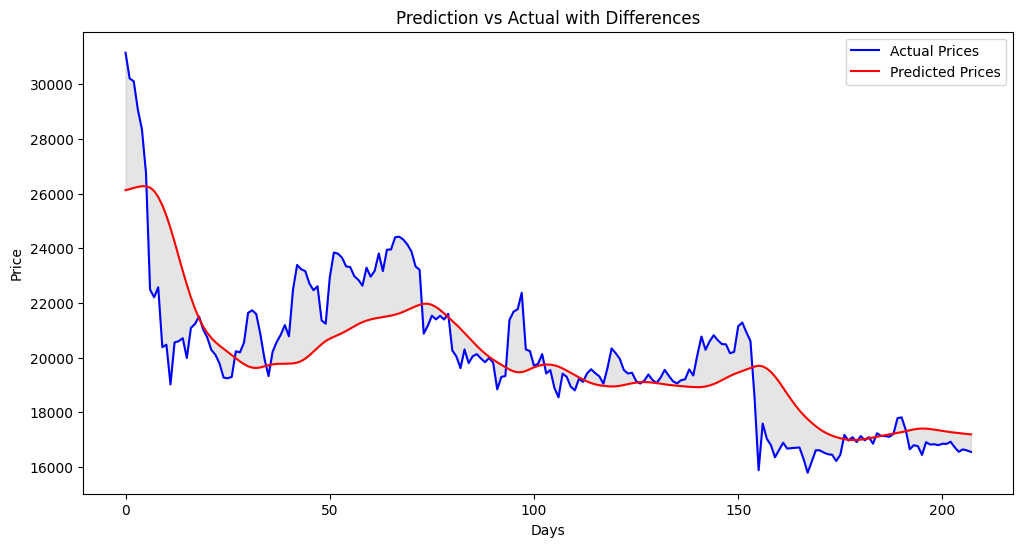

In [ ]:
btc_predicted_prices = btc_model.predict(X_test_btc)
btc_predicted_prices = btc_scaler.inverse_transform(btc_predicted_prices)
btc_actual_prices = btc_scaler.inverse_transform(y_test_btc.reshape(-1, 1))

plot_predictions(btc_actual_prices, btc_predicted_prices, title="BTC Prediction vs Actual")
compare_predictions(btc_actual_prices, btc_predicted_prices)


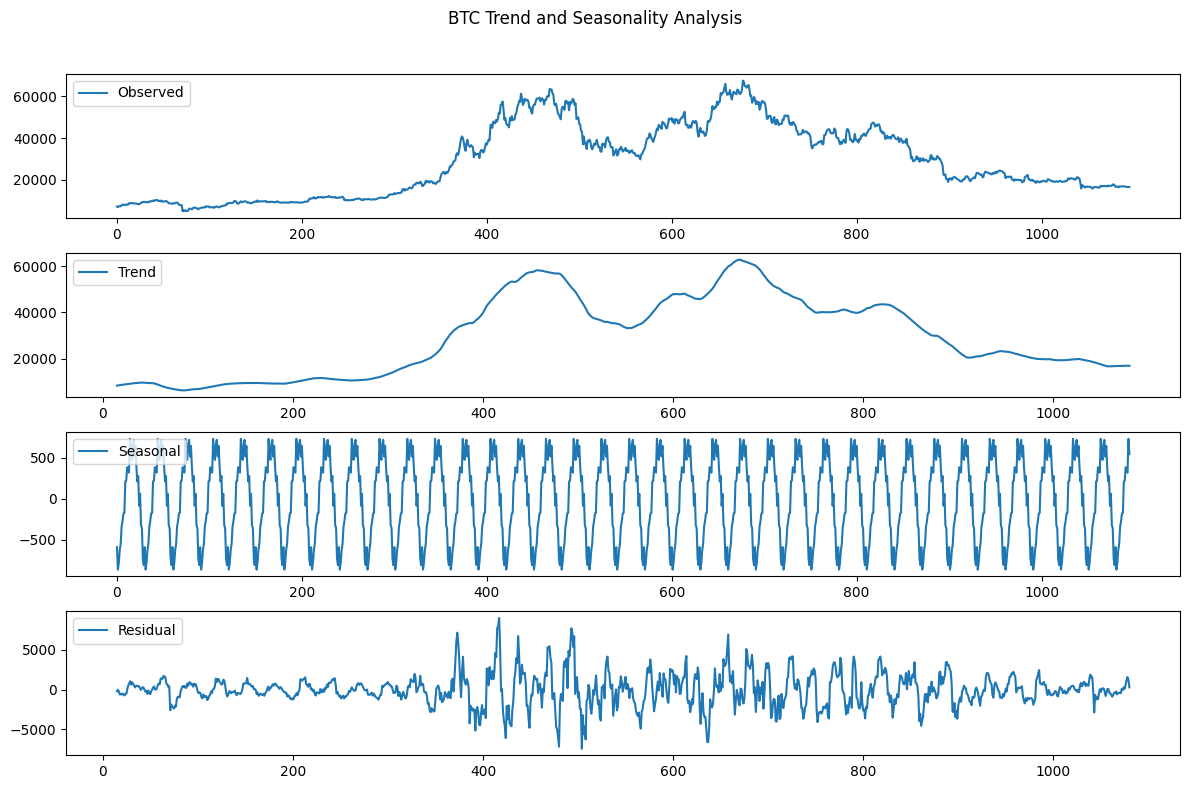

In [ ]:
plot_trend_and_seasonality(btc_closing_prices, title="BTC Trend and Seasonality Analysis")


In [ ]:
# BTC Detrend
btc_closing_prices_detrended = detrend_data(btc_closing_prices)
btc_closing_prices_detrended_scaled = btc_scaler.fit_transform(btc_closing_prices_detrended.reshape(-1, 1))


In [ ]:
# Create detrend Sequence
X_btc_detrended, y_btc_detrended = create_sequences(btc_closing_prices_detrended_scaled, sequence_length)
X_train_btc_det, X_test_btc_det = X_btc_detrended[:train_size_btc], X_btc_detrended[train_size_btc:]
y_train_btc_det, y_test_btc_det = y_btc_detrended[:train_size_btc], y_btc_detrended[train_size_btc:]


In [ ]:
# Training model
btc_history_detrended = btc_model.fit(
    X_train_btc_det, y_train_btc_det,
    validation_data=(X_test_btc_det, y_test_btc_det),
    epochs=100,
    batch_size=64,
    callbacks=btc_callbacks
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0130 - mae: 0.1196 - val_loss: 0.0033 - val_mae: 0.0568 - learning_rate: 1.2500e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0115 - mae: 0.1057 - val_loss: 0.0030 - val_mae: 0.0526 - learning_rate: 1.2500e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0113 - mae: 0.1046 - val_loss: 0.0030 - val_mae: 0.0542 - learning_rate: 1.2500e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0104 - mae: 0.1022 - val_loss: 0.0028 - val_mae: 0.0514 - learning_rate: 1.2500e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0107 - mae: 0.1028 - val_loss: 0.0028 - val_mae: 0.0516 - learning_rate: 1.2500e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0102 - mae: 0.0998 - val_loss: 0.0028 - val_mae: 0.0531 - learning_rate: 1.2500e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0102 - mae: 0.0979 - val_loss: 0.0026 - val_mae: 0.0502 - lear

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
btc_actual_prices_restored shape: (208, 1)
btc_predicted_prices_restored shape: (208, 1)


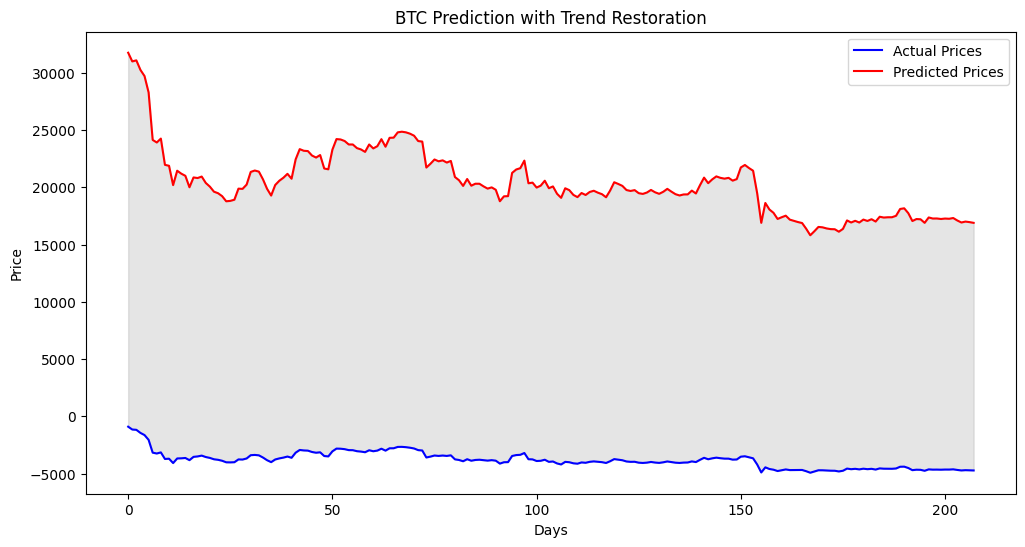

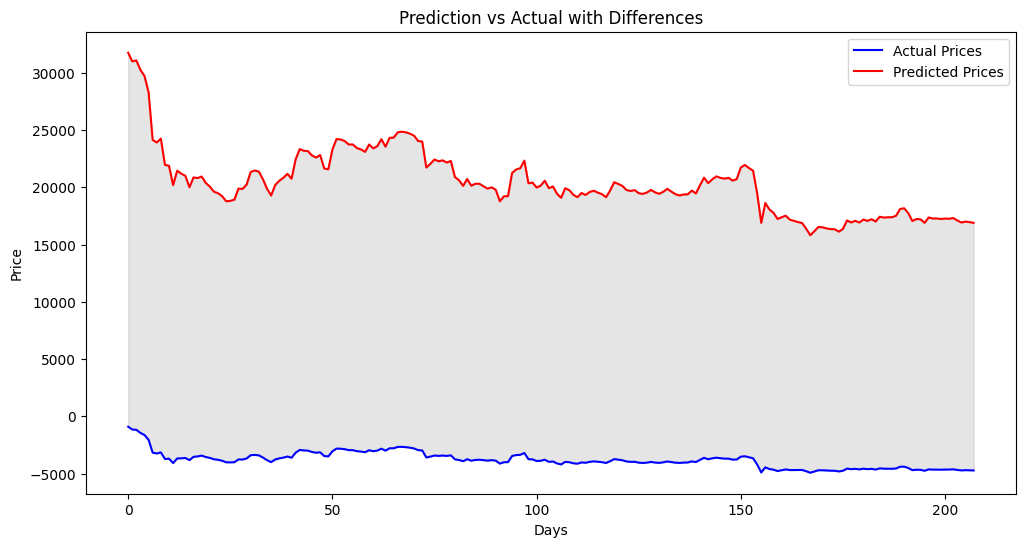

In [ ]:
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01')
btc_closing_prices = btc_data['Close'].values
btc_closing_prices = pd.Series(btc_closing_prices).interpolate().values

# HP Filter로 추세 및 잔차 분리
btc_trend, btc_detrended = hpfilter(btc_closing_prices, lamb=1600)

# 잔차 데이터 정규화
btc_scaler_detrended = MinMaxScaler(feature_range=(0, 1))
btc_detrended_scaled = btc_scaler_detrended.fit_transform(btc_detrended.reshape(-1, 1))

# 추세 데이터 정규화 (필요 시)
btc_scaler_trend = MinMaxScaler(feature_range=(0, 1))
btc_trend_scaled = btc_scaler_trend.fit_transform(btc_trend.reshape(-1, 1))

# 잔차 데이터로 시퀀스 생성
X_train_btc_det, y_train_btc_det = create_sequences(btc_detrended_scaled[:train_size_btc], sequence_length)
X_test_btc_det, y_test_btc_det = create_sequences(btc_detrended_scaled[train_size_btc:], sequence_length)

# LSTM 모델 학습 (잔차 데이터)
btc_history_detrended = btc_model.fit(
    X_train_btc_det, y_train_btc_det,
    validation_data=(X_test_btc_det, y_test_btc_det),
    epochs=100,
    batch_size=64,
    callbacks=btc_callbacks
)

# 잔차 예측
btc_predicted_prices_detrended = btc_model.predict(X_test_btc_det)

# 추세 복원
start_idx = train_size_btc + sequence_length
end_idx = start_idx + len(btc_predicted_prices_detrended)

# 슬라이싱 범위 초과 방지
if end_idx > len(btc_trend):
    end_idx = len(btc_trend)

trend_component = btc_trend[start_idx:end_idx].reshape(-1, 1)
btc_predicted_prices_restored = btc_scaler_detrended.inverse_transform(btc_predicted_prices_detrended) + trend_component

# 실제 값 복원
btc_actual_prices_restored = btc_closing_prices[start_idx:end_idx].reshape(-1, 1)

# 길이 맞추기
min_len = min(len(btc_actual_prices_restored), len(btc_predicted_prices_restored))
btc_actual_prices_restored = btc_actual_prices_restored[:min_len]
btc_predicted_prices_restored = btc_predicted_prices_restored[:min_len]

# 시각화
print(f"btc_actual_prices_restored shape: {btc_actual_prices_restored.shape}")
print(f"btc_predicted_prices_restored shape: {btc_predicted_prices_restored.shape}")

plot_predictions(btc_actual_prices_restored, btc_predicted_prices_restored, title="BTC Prediction with HP Filter Restoration")
compare_predictions(btc_actual_prices_restored, btc_predicted_prices_restored)